In [9]:
import geopandas as gdp

from shapely.geometry import Point
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
import numpy as np
import pandas as pd
import seaborn as sns

import folium
import contextily as cx


# ==============================================================================
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA


In [10]:
def plot_2d_clusters(x,y,ax):
    y_uniques = pd.Series(y).unique()

    for _ in y_uniques:
        x[y==_].plot(
            title=f'{len(y_uniques)} Clusters',
            kind='scatter',
            x='x1',
            y='x2',
            marker = f'${_}$',
            ax = ax
        )

Cleaning Data

In [81]:
iv = pd.read_csv('/home/camilocorredor/DS_P/Spatial_cluster/Carbones_de_Colombia:_Clasificación_ASTM.csv')


In [12]:
iv.shape

(186, 25)

In [13]:
iv.dtypes

X             float64
Y             float64
FID             int64
Referencia     object
Año             int64
Longitud      float64
Latitud       float64
Municipio      object
Departamen     object
Zona_Carbo     object
Manto          object
Espesor        object
Cenizas__     float64
SO3_bs___e    float64
C_Fijo_Cal    float64
S_bs___en     float64
C_Fijo_he_    float64
Cenizas_he     object
S_he___en     float64
C_Fijo_lmm    float64
Materia_Vo    float64
Poder_Calo    float64
Poder_Ca_1    float64
Poder_Ca_2    float64
CLASIFICAC     object
dtype: object

In [14]:
iv.isnull().sum()

X              0
Y              0
FID            0
Referencia     0
Año            0
Longitud       0
Latitud        0
Municipio      0
Departamen     0
Zona_Carbo     0
Manto          0
Espesor       15
Cenizas__      0
SO3_bs___e     0
C_Fijo_Cal     0
S_bs___en      0
C_Fijo_he_     0
Cenizas_he     0
S_he___en      0
C_Fijo_lmm     0
Materia_Vo     0
Poder_Calo     0
Poder_Ca_1     0
Poder_Ca_2     0
CLASIFICAC     0
dtype: int64

In [15]:
print(iv.loc[iv['Municipio']=='Gámeza'].shape)
print(iv.loc[iv['Municipio']=='Gameza'].shape)

(5, 25)
(3, 25)


In [16]:
iv = iv.replace(['Gameza'], 'Gámeza')
print(iv.loc[iv['Municipio']=='Gámeza'].shape)
print(iv.loc[iv['Municipio']=='Gameza'].shape)

(8, 25)
(0, 25)


In [17]:
Dep = pd.DataFrame(iv.groupby(by = 'Departamen', as_index=False).size())

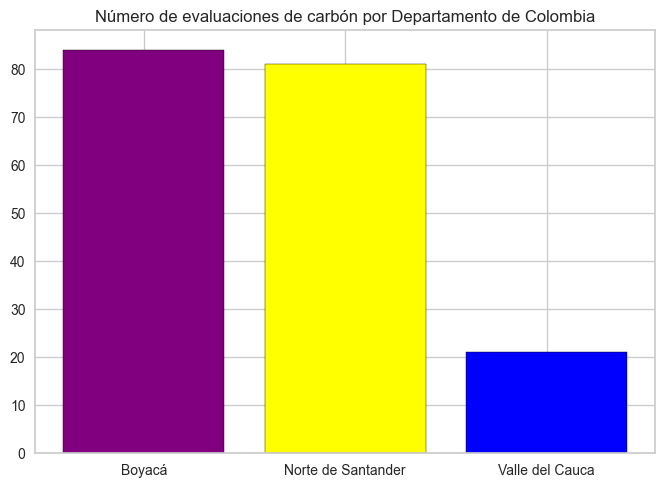

In [18]:
y_pos = np.arange(len(list(Dep['size'])))
# Create bars
plt.bar(y_pos, list(Dep['size']), color=['purple','yellow','blue'],  edgecolor='black')
# Create names on the x-axis
plt.xticks(y_pos, Dep['Departamen'], rotation = 'horizontal')
plt.title('Número de evaluaciones de carbón por Departamento de Colombia')

plt.show()

In [82]:
iv.drop(['X','Y'], axis=1, inplace=True)

In [88]:
gdf = gdp.GeoDataFrame(iv, geometry=gdp.points_from_xy(iv.Longitud, iv.Latitud)).set_crs('epsg:4326')

In [89]:
gdf

FID   Referencia   Año   Longitud   Latitud Municipio       Departamen  \
0      1  15820804A01  2017 -72.822253  5.790460    Topaga           Boyacá   
1      2  15820804A02  2017 -72.821525  5.789365    Topaga           Boyacá   
2      3  15820804A03  2017 -72.856416  5.758793    Topaga           Boyacá   
3      4  15820804A04  2017 -72.856416  5.758793    Topaga           Boyacá   
4      5  15516803A05  2017 -73.168640  5.762767     Paipa           Boyacá   
..   ...          ...   ...        ...       ...       ...              ...   
181  182       FRB 55  2001 -76.646610  3.156078   Jamundí  Valle del Cauca   
182  183       FRB 56  2001 -76.646610  3.156078   Jamundí  Valle del Cauca   
183  184       FRB 57  2001 -76.630933  3.166959   Jamundí  Valle del Cauca   
184  185       FRB 58  2001 -76.630933  3.166959   Jamundí  Valle del Cauca   
185  186       FRB 59  2001 -76.630933  3.166959   Jamundí  Valle del Cauca   

         Zona_Carbo            Manto Espesor  ...  C_Fijo_he_  Cenizas_he  \
0            Boyacá        1,20-1,40     1,4  ...       46.68       15.07   
1            Boyacá       Vetagrande     2,2  ...       49.38        7.41   
2            Boyacá          Manto-5     NaN  ...       49.76        8.33   
3            Boyacá          Manto-6    n.d.  ...       37.76       22.85   
4            Boyacá       La Siscuda     1,8  ...       51.90        3.41   
..              ...              ...     ...  ...         ...         ...   
181  Yumbo - Suárez                3     1,1  ...       35.46       26.63   
182  Yumbo - Suárez        La Gasosa     0,9  ...       39.31        7.23   
183  Yumbo - Suárez                7     0,8  ...       41.05       14.22   
184  Yumbo - Suárez    9 (La Grande)       1  ...       39.68       17.72   
185  Yumbo - Suárez  6 (La Melugosa)     1,1  ...       32.77       25.78   

     S_he___en  C_Fijo_lmm  Materia_Vo Poder_Calo  Poder_Ca_1  Poder_Ca_2  \
0         2.55       58.23       41.77   12275.76    11930.81    14338.11   
1         0.92       55.55       44.45   13516.03    13130.83    14302.43   
2         0.91       57.58       42.42   13355.74    12777.44    14067.23   
3         0.99       52.99       47.01   10842.66    10430.64    13881.97   
4         1.12       56.52       43.48   14199.69    13606.14    14158.27   
..         ...         ...         ...        ...         ...         ...   
181       5.51       52.06       47.94   10398.80    10224.10    14586.03   
182       1.10       43.18       56.82   14181.96    14050.07    15279.90   
183       4.75       50.22       49.78   12714.83    12496.14    14944.19   
184       2.96       50.66       49.34   11842.26    11630.28    14491.52   
185       3.83       47.24       52.76   10367.61    10170.62    14245.31   

                         CLASIFICAC                   geometry  
0    Bituminoso Alto en Volátiles A  POINT (-72.82225 5.79046)  
1    Bituminoso Alto en Volátiles A  POINT (-72.82152 5.78936)  
2    Bituminoso Alto en Volátiles A  POINT (-72.85642 5.75879)  
3    Bituminoso Alto en Volátiles B  POINT (-72.85642 5.75879)  
4    Bituminoso Alto en Volátiles A  POINT (-73.16864 5.76277)  
..                              ...                        ...  
181  Bituminoso Alto en Volátiles A  POINT (-76.64661 3.15608)  
182  Bituminoso Alto en Volátiles A  POINT (-76.64661 3.15608)  
183  Bituminoso Alto en Volátiles A  POINT (-76.63093 3.16696)  
184  Bituminoso Alto en Volátiles A  POINT (-76.63093 3.16696)  
185  Bituminoso Alto en Volátiles A  POINT (-76.63093 3.16696)  

[186 rows x 24 columns]

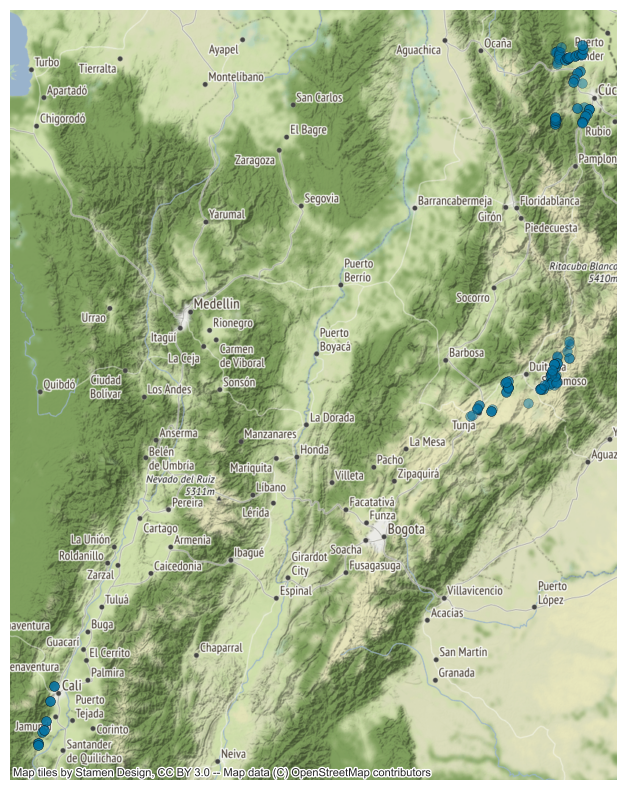

In [86]:
gdf = gdf.to_crs(epsg=3857) 
ax = gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
cx.add_basemap(ax)
ax.set_axis_off()

In [21]:
#This map can't see on GitHub
m = folium.Map([5.5, -74.5], tiles="Stamen Toner",  zoom_start=8)
 
folium.Choropleth(
    gdf,
    icon=folium.Icon(color='red'),
    line_color='red'
).add_to(m)

m

In [22]:
Mun = pd.DataFrame(iv.groupby(by='Municipio',as_index=False).size())
height = (list(Mun['Municipio']))
bars = list(Mun['size'])

In [23]:
height

['Arboledas',
 'Beteitiva',
 'Buenos Aires',
 'Cali',
 'Chivata',
 'Corrales',
 'Cucaita',
 'Gámeza',
 'Iza',
 'Jamundí',
 'Mongua',
 'Motavita',
 'Paipa',
 'Paz Del Rio',
 'Salázar',
 'San Cayetano',
 'Sardinata',
 'Sativasur',
 'Socha',
 'Sogamoso',
 'Tasco',
 'Topaga',
 'Tuta',
 'Zulia']

In [24]:
print(iv.loc[iv['Municipio']=='Gámeza'].shape)
print(iv.loc[iv['Municipio']=='Gameza'].shape)

(8, 26)
(0, 26)


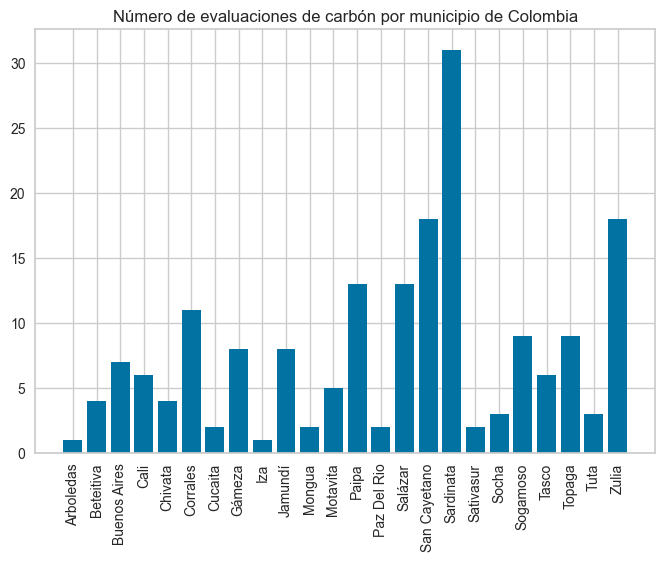

In [25]:
y_pos = np.arange(len(bars))
# Create bars
plt.bar(y_pos, bars)
# Create names on the x-axis
plt.xticks(y_pos, height, rotation = 'vertical')
plt.title('Número de evaluaciones de carbón por municipio de Colombia')

plt.show()

In [26]:
Class = iv.groupby('CLASIFICAC', as_index = False).size()
Class

CLASIFICAC  size
0  Bituminoso Alto en Volátiles A   142
1  Bituminoso Alto en Volátiles B    28
2  Bituminoso Alto en Volátiles C    12
3   Bituminoso Medio en Volátiles     4

In [27]:
bar_ = list(Class['CLASIFICAC'])
height_ = list(Class['size'])

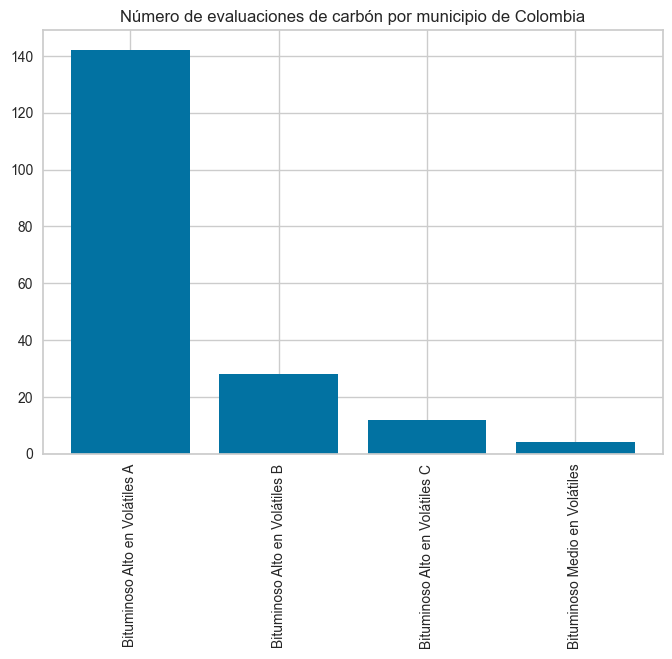

In [28]:
y_pos = np.arange(len(list(Class['size'])))
# Create bars
plt.bar(y_pos, list(Class['size']))
# Create names on the x-axis
plt.xticks(y_pos, list(Class['CLASIFICAC']), rotation = 'vertical')
plt.title('Número de evaluaciones de carbón por municipio de Colombia')

plt.show()

In [29]:
data = pd.DataFrame({'Cenizas__' : iv['Cenizas__'],
            'SO3_bs___e' : iv['SO3_bs___e'],
            'C_Fijo_Cal' : iv['C_Fijo_Cal'],
            'S_bs___en' : iv['S_bs___en'],
            'C_Fijo_he_' : iv['C_Fijo_he_'],
            'S_he___en' : iv['S_he___en'],
            'C_Fijo_lmm' : iv['C_Fijo_lmm'],
            'Materia_Vo' : iv['Materia_Vo'],
            'Poder_Calo' : iv['Poder_Calo'],
            'Poder_Ca_1' : iv['Poder_Ca_1'],
            'Poder_Ca_2' : iv['Poder_Ca_2']})

In [30]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
iv_scaled = scaler.fit_transform(data)

df_scaled = pd.DataFrame(iv_scaled,columns = data.columns)

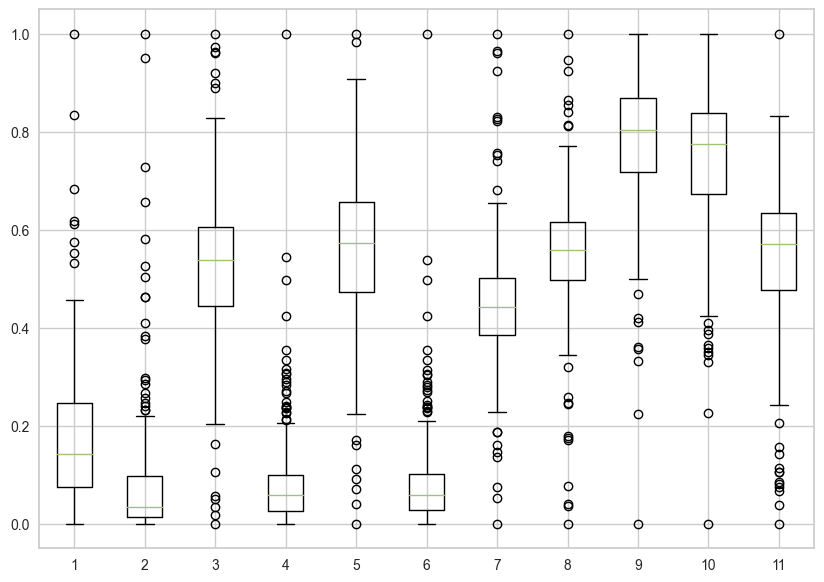

In [31]:
# data_3 = np.random.normal(80, 30, 200)
# data_4 = np.random.normal(70, 40, 200)
fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(df_scaled)
 
# show plot
plt.show()

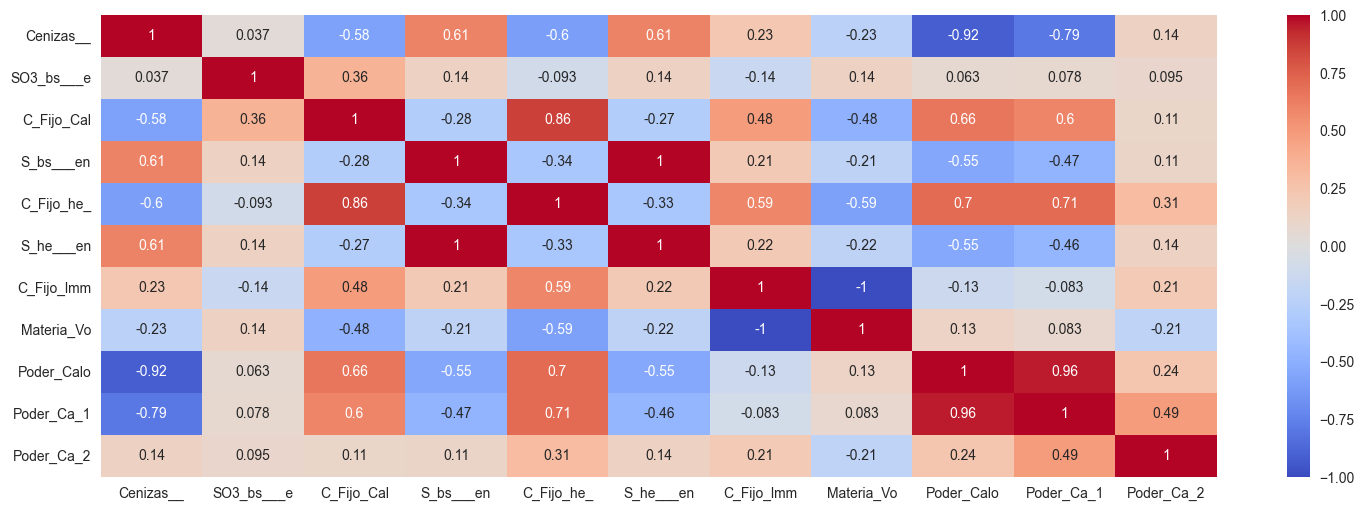

In [32]:
corr = df_scaled.corr()
fig, ax  = plt.subplots(figsize =(18,6))
sns.heatmap(corr, annot=True, annot_kws={'size':10}, cmap='coolwarm', ax = ax)
plt.show()

In [33]:
data2 = pd.DataFrame({'Cenizas__' : iv['Cenizas__'],
            'SO3_bs___e' : iv['SO3_bs___e'],
            'C_Fijo_Cal' : iv['C_Fijo_Cal'],
            'S_bs___en' : iv['S_bs___en'],
            'C_Fijo_he_' : iv['C_Fijo_he_'],
            'S_he___en' : iv['S_he___en'],
            'C_Fijo_lmm' : iv['C_Fijo_lmm'],
            'Materia_Vo' : iv['Materia_Vo'],
            'Poder_Calo' : iv['Poder_Calo'],
            'Poder_Ca_1' : iv['Poder_Ca_1'],
            'Poder_Ca_2' : iv['Poder_Ca_2'],
            'CLASIFICACION' : iv['CLASIFICAC']})

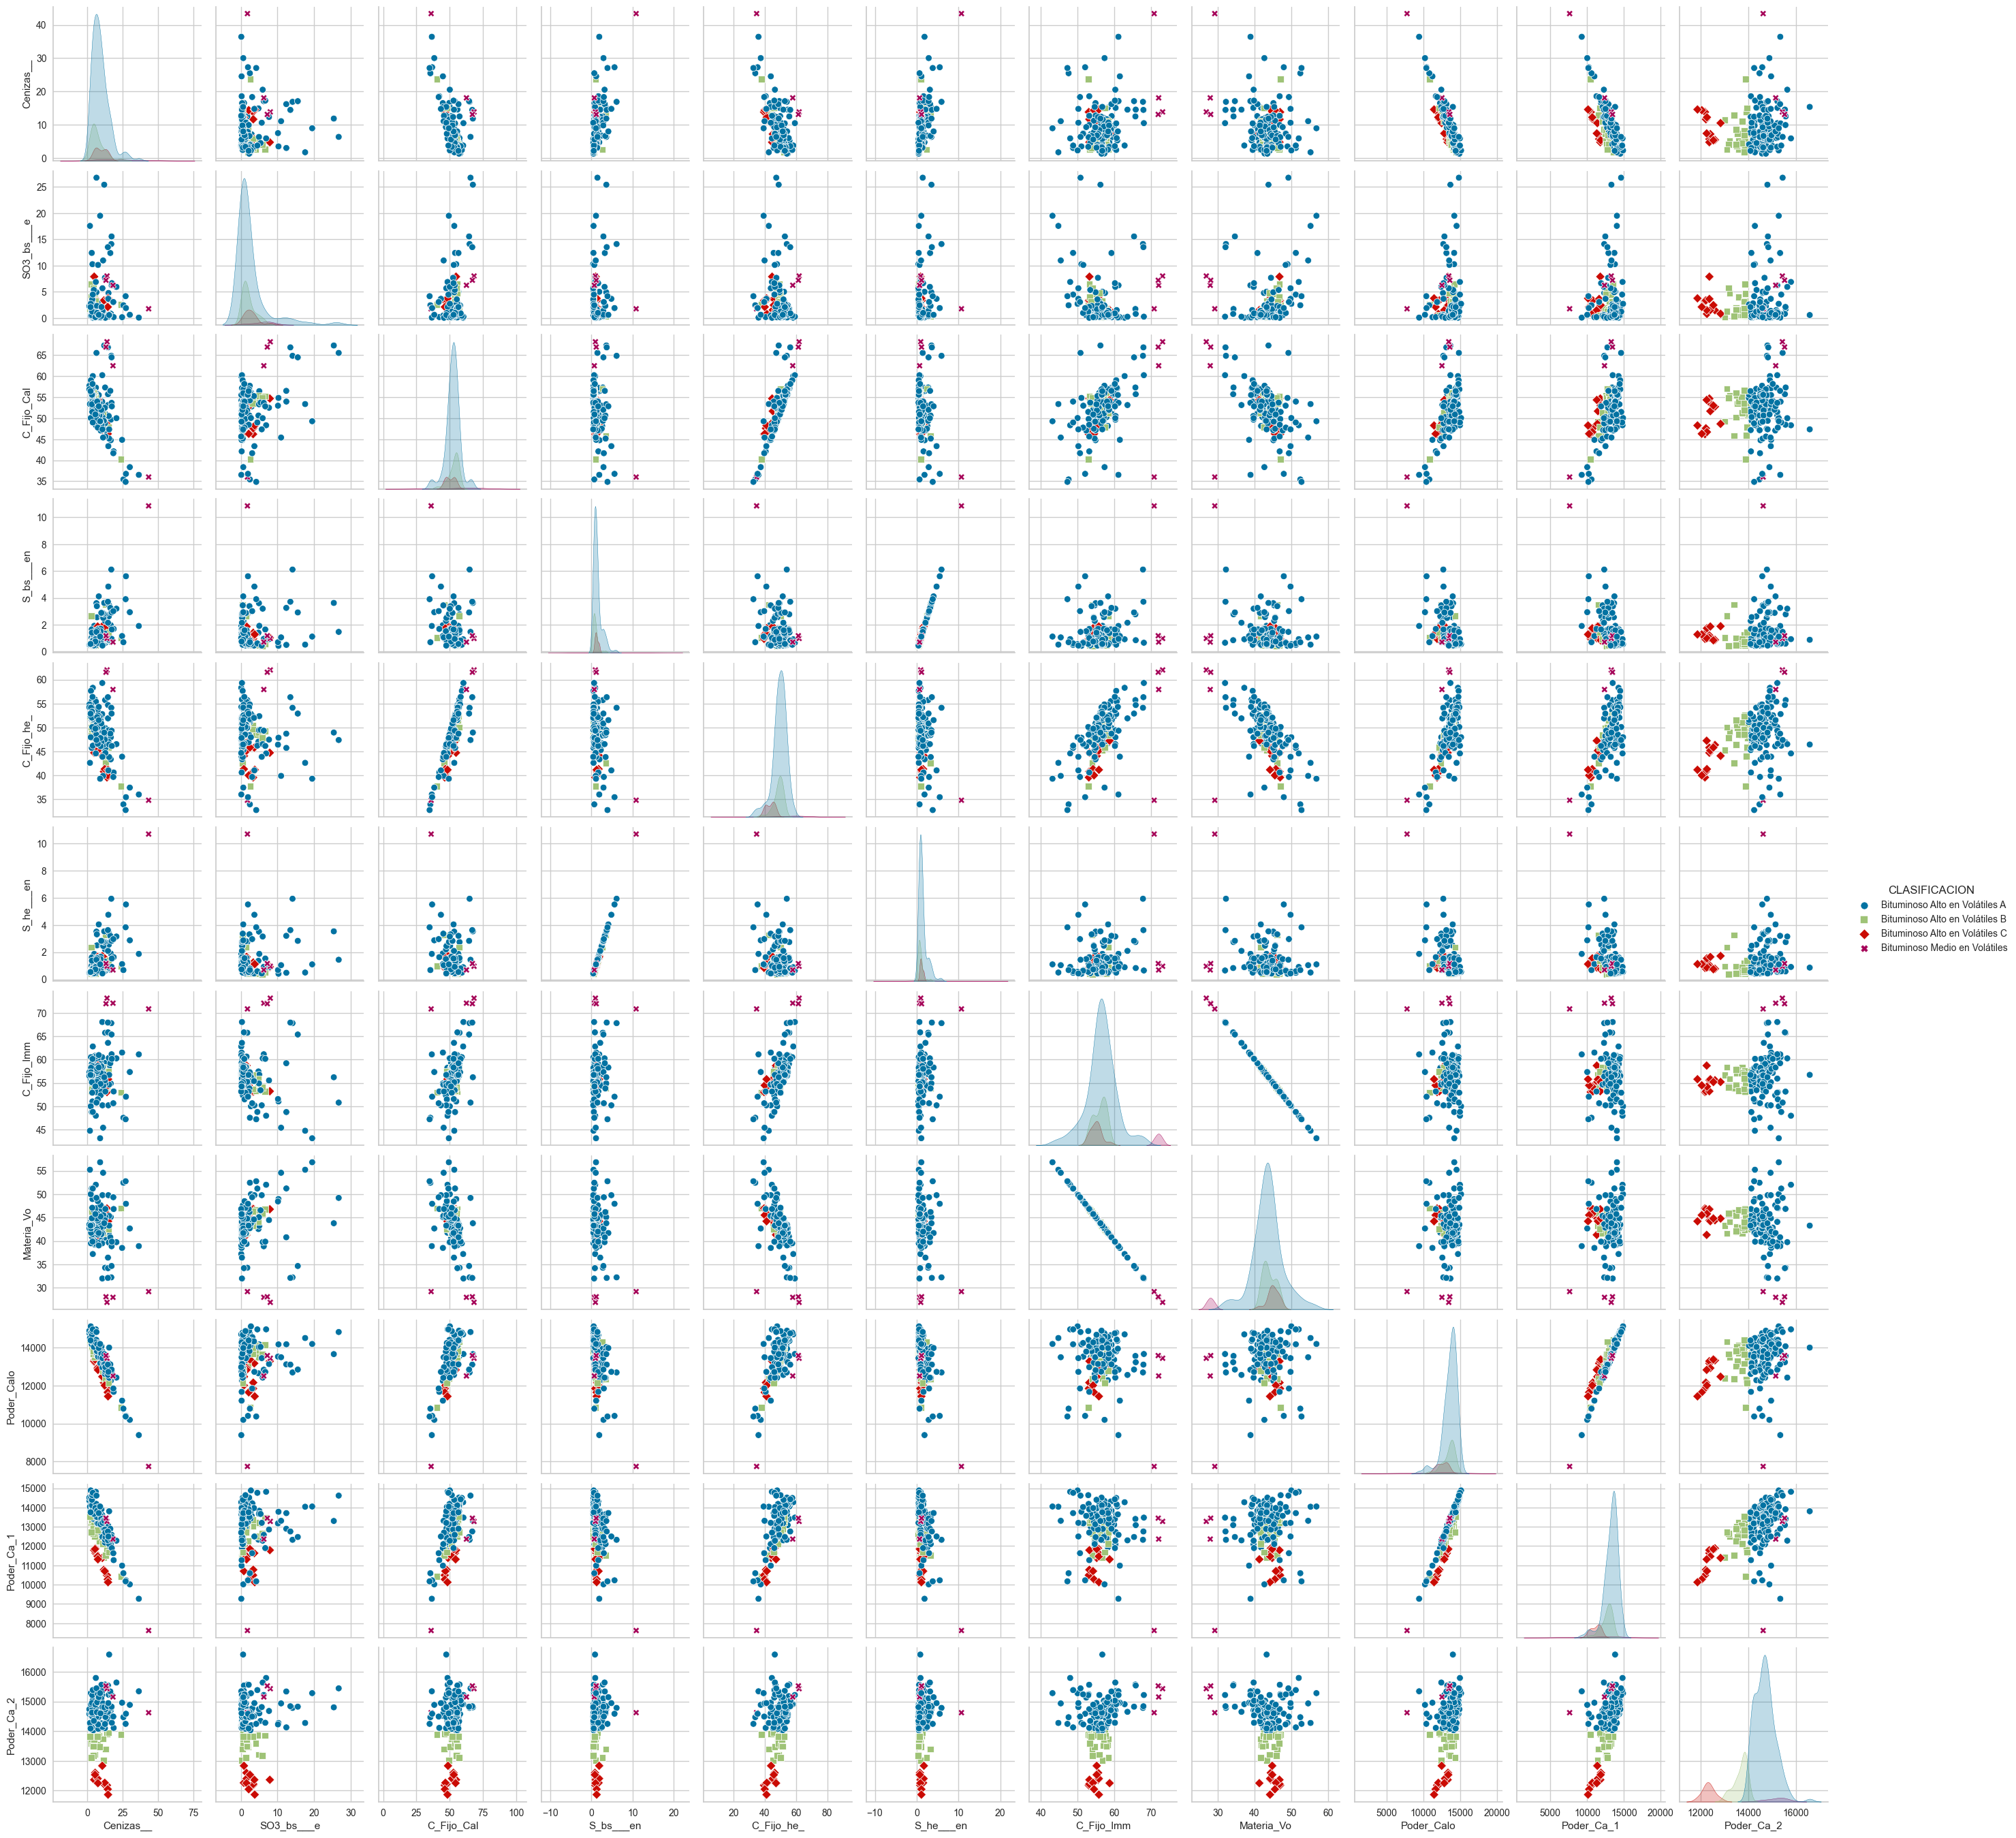

In [34]:
sns.pairplot(data2, hue = 'CLASIFICACION', markers=["o", "s", "D","X"])

In [35]:
pca = PCA()
pca.fit(df_scaled)
pca_data_scaled = pca.transform(df_scaled)


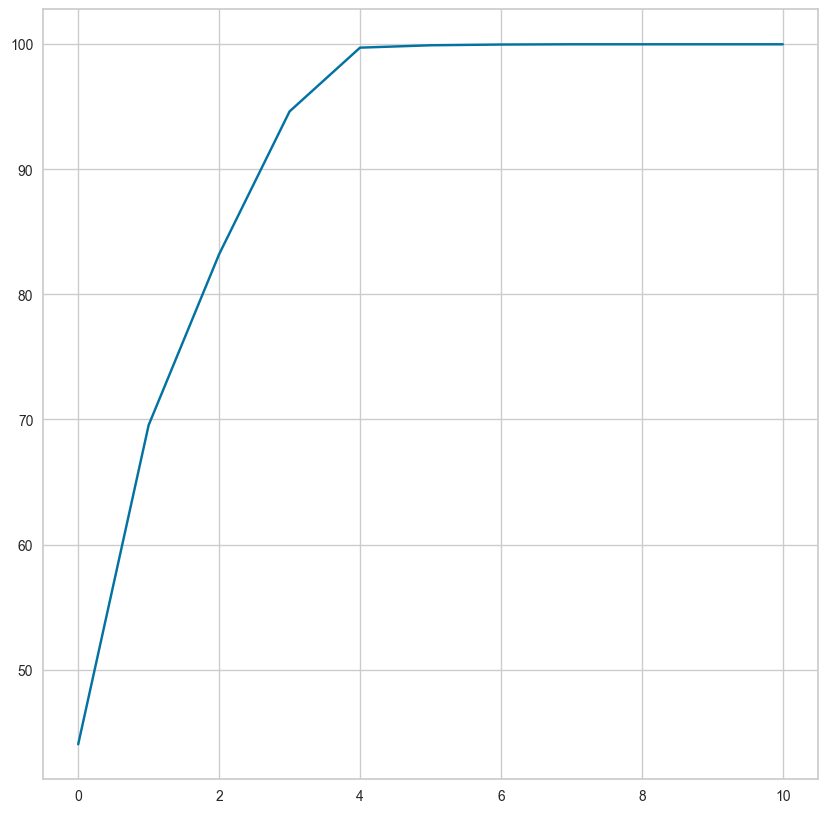

In [36]:
var = pca.explained_variance_ratio_
cum_var = np.cumsum(np.round(var, decimals=4)*100) 
plt.figure(figsize=(10,10))
plt.plot(cum_var, 'b-x')
plt.show()

In [37]:
pca_data_standard = pd.DataFrame(pca_data_scaled)

pca_data_standard.drop([3,4,5,6,7,8,9,10],axis=1, inplace=True)


In [38]:
Sum_of_squared_distances = []
silhouette_scores = []
K = range(2,15) 
for _ in K:
    km = KMeans(n_clusters = _, n_init = 10)
    y = km.fit_predict(pca_data_standard)
    Sum_of_squared_distances.append(km.inertia_)
    silhouette_scores.append(silhouette_score(pca_data_standard,y))

[Text(0.5, 0, 'No Clusters'), Text(0, 0.5, ' Score')]

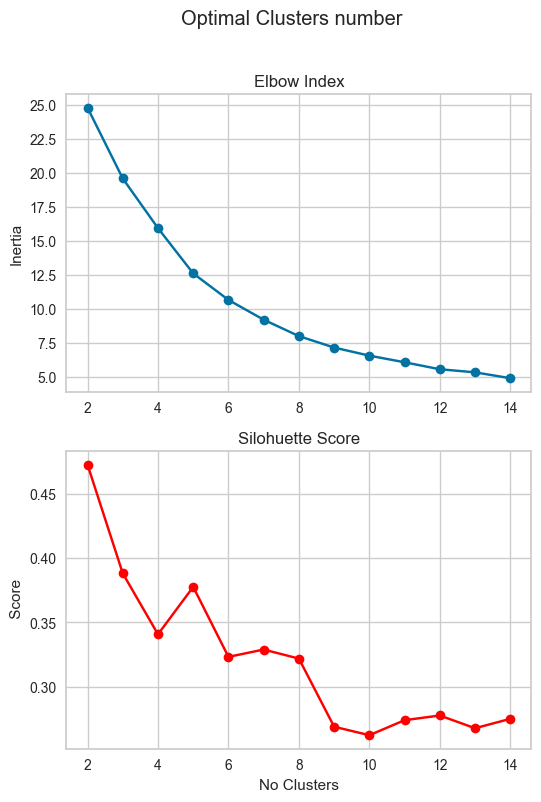

In [174]:
fig, axs = plt.subplots(2)
fig.set_size_inches(6,8.5)
fig.suptitle('Optimal Clusters number')
axs[0].plot(K, Sum_of_squared_distances, marker = 'o')
axs[1].plot(K, silhouette_scores,color = 'red', marker = 'o')
axs[0].set_title('Elbow Index')
axs[1].set_title('Silohuette Score')
axs[0].set(xlabel = '', ylabel = 'Inertia')
axs[1].set(xlabel = 'No Clusters', ylabel = ' Score')

In [40]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [41]:
def silhouette_analysis(X):
    range_n_clusters = [4, 5, 6]

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(19, 4)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, n_init = 'auto',random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = plt.cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = plt.cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='o', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for %s clustering on sample data "
                      "with n_clusters = %d, score = %.3f" % (clusterer.__class__.__name__, n_clusters,silhouette_avg)),
                     fontsize=14, fontweight='bold')

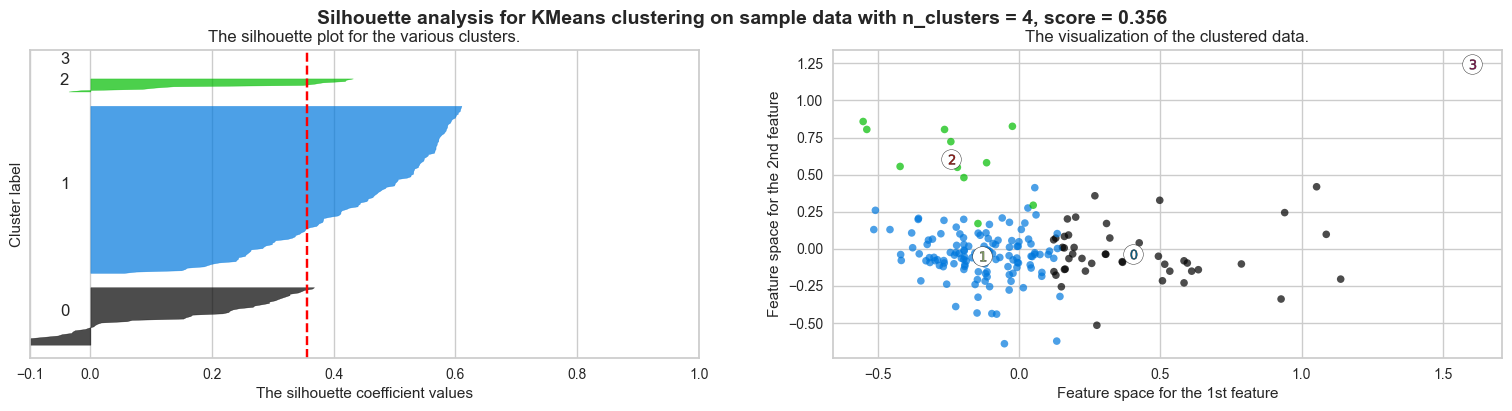

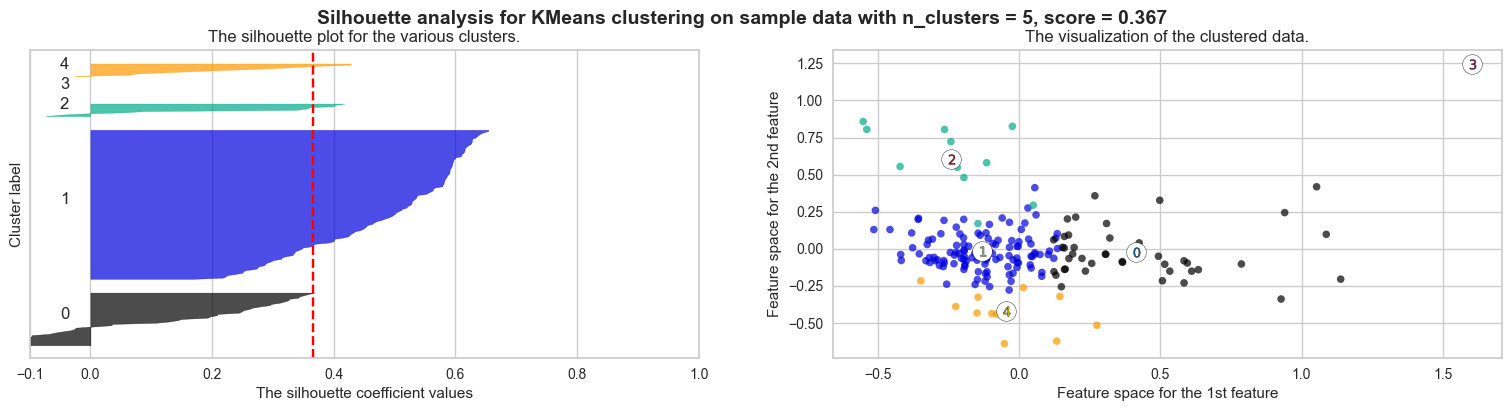

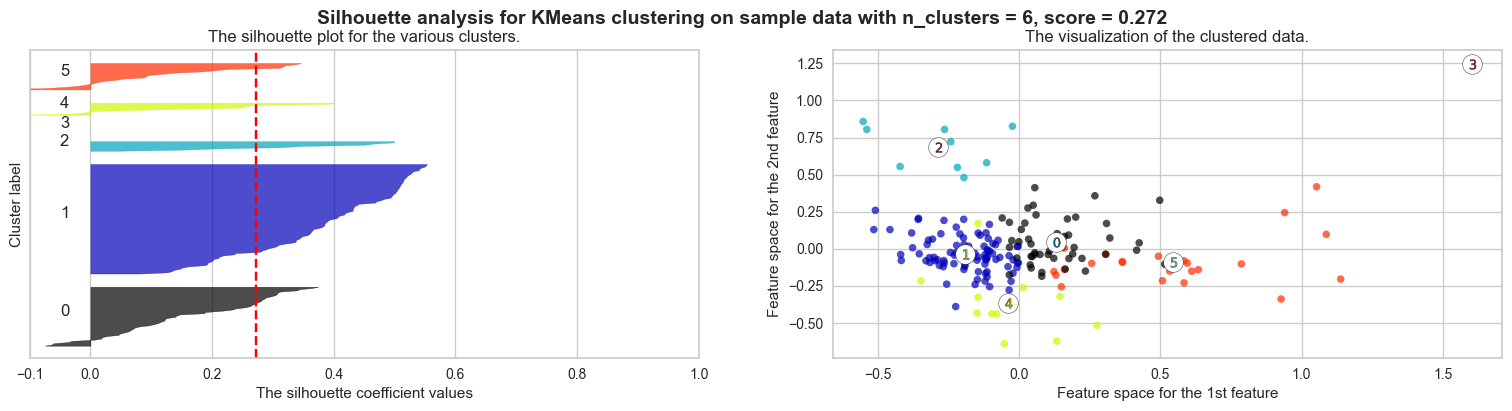

In [42]:
silhouette_analysis(np.array(pca_data_scaled))

In [43]:
km = KMeans(n_clusters = 5, n_init = 10)
y = km.fit_predict(pca_data_standard)

data2['K_Means'] = y

In [ ]:
gdf['K_Means'] = y

In [264]:
km.labels_

array([2, 3, 3, 0, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 2, 3, 3, 3, 3, 2, 2, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3, 3, 2, 3,
       2, 2, 3, 3, 2, 1, 1, 1, 3, 3, 3, 0, 2, 3, 3, 3, 3, 3, 3, 3, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3,
       2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3,
       4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 3, 3, 2,
       3, 4, 4, 3, 3, 3, 3, 0, 3, 3, 3, 0, 4, 4, 1, 1, 1, 0, 2, 4, 1, 4,
       1, 1, 1, 1, 1, 0, 4, 2, 2, 0], dtype=int32)

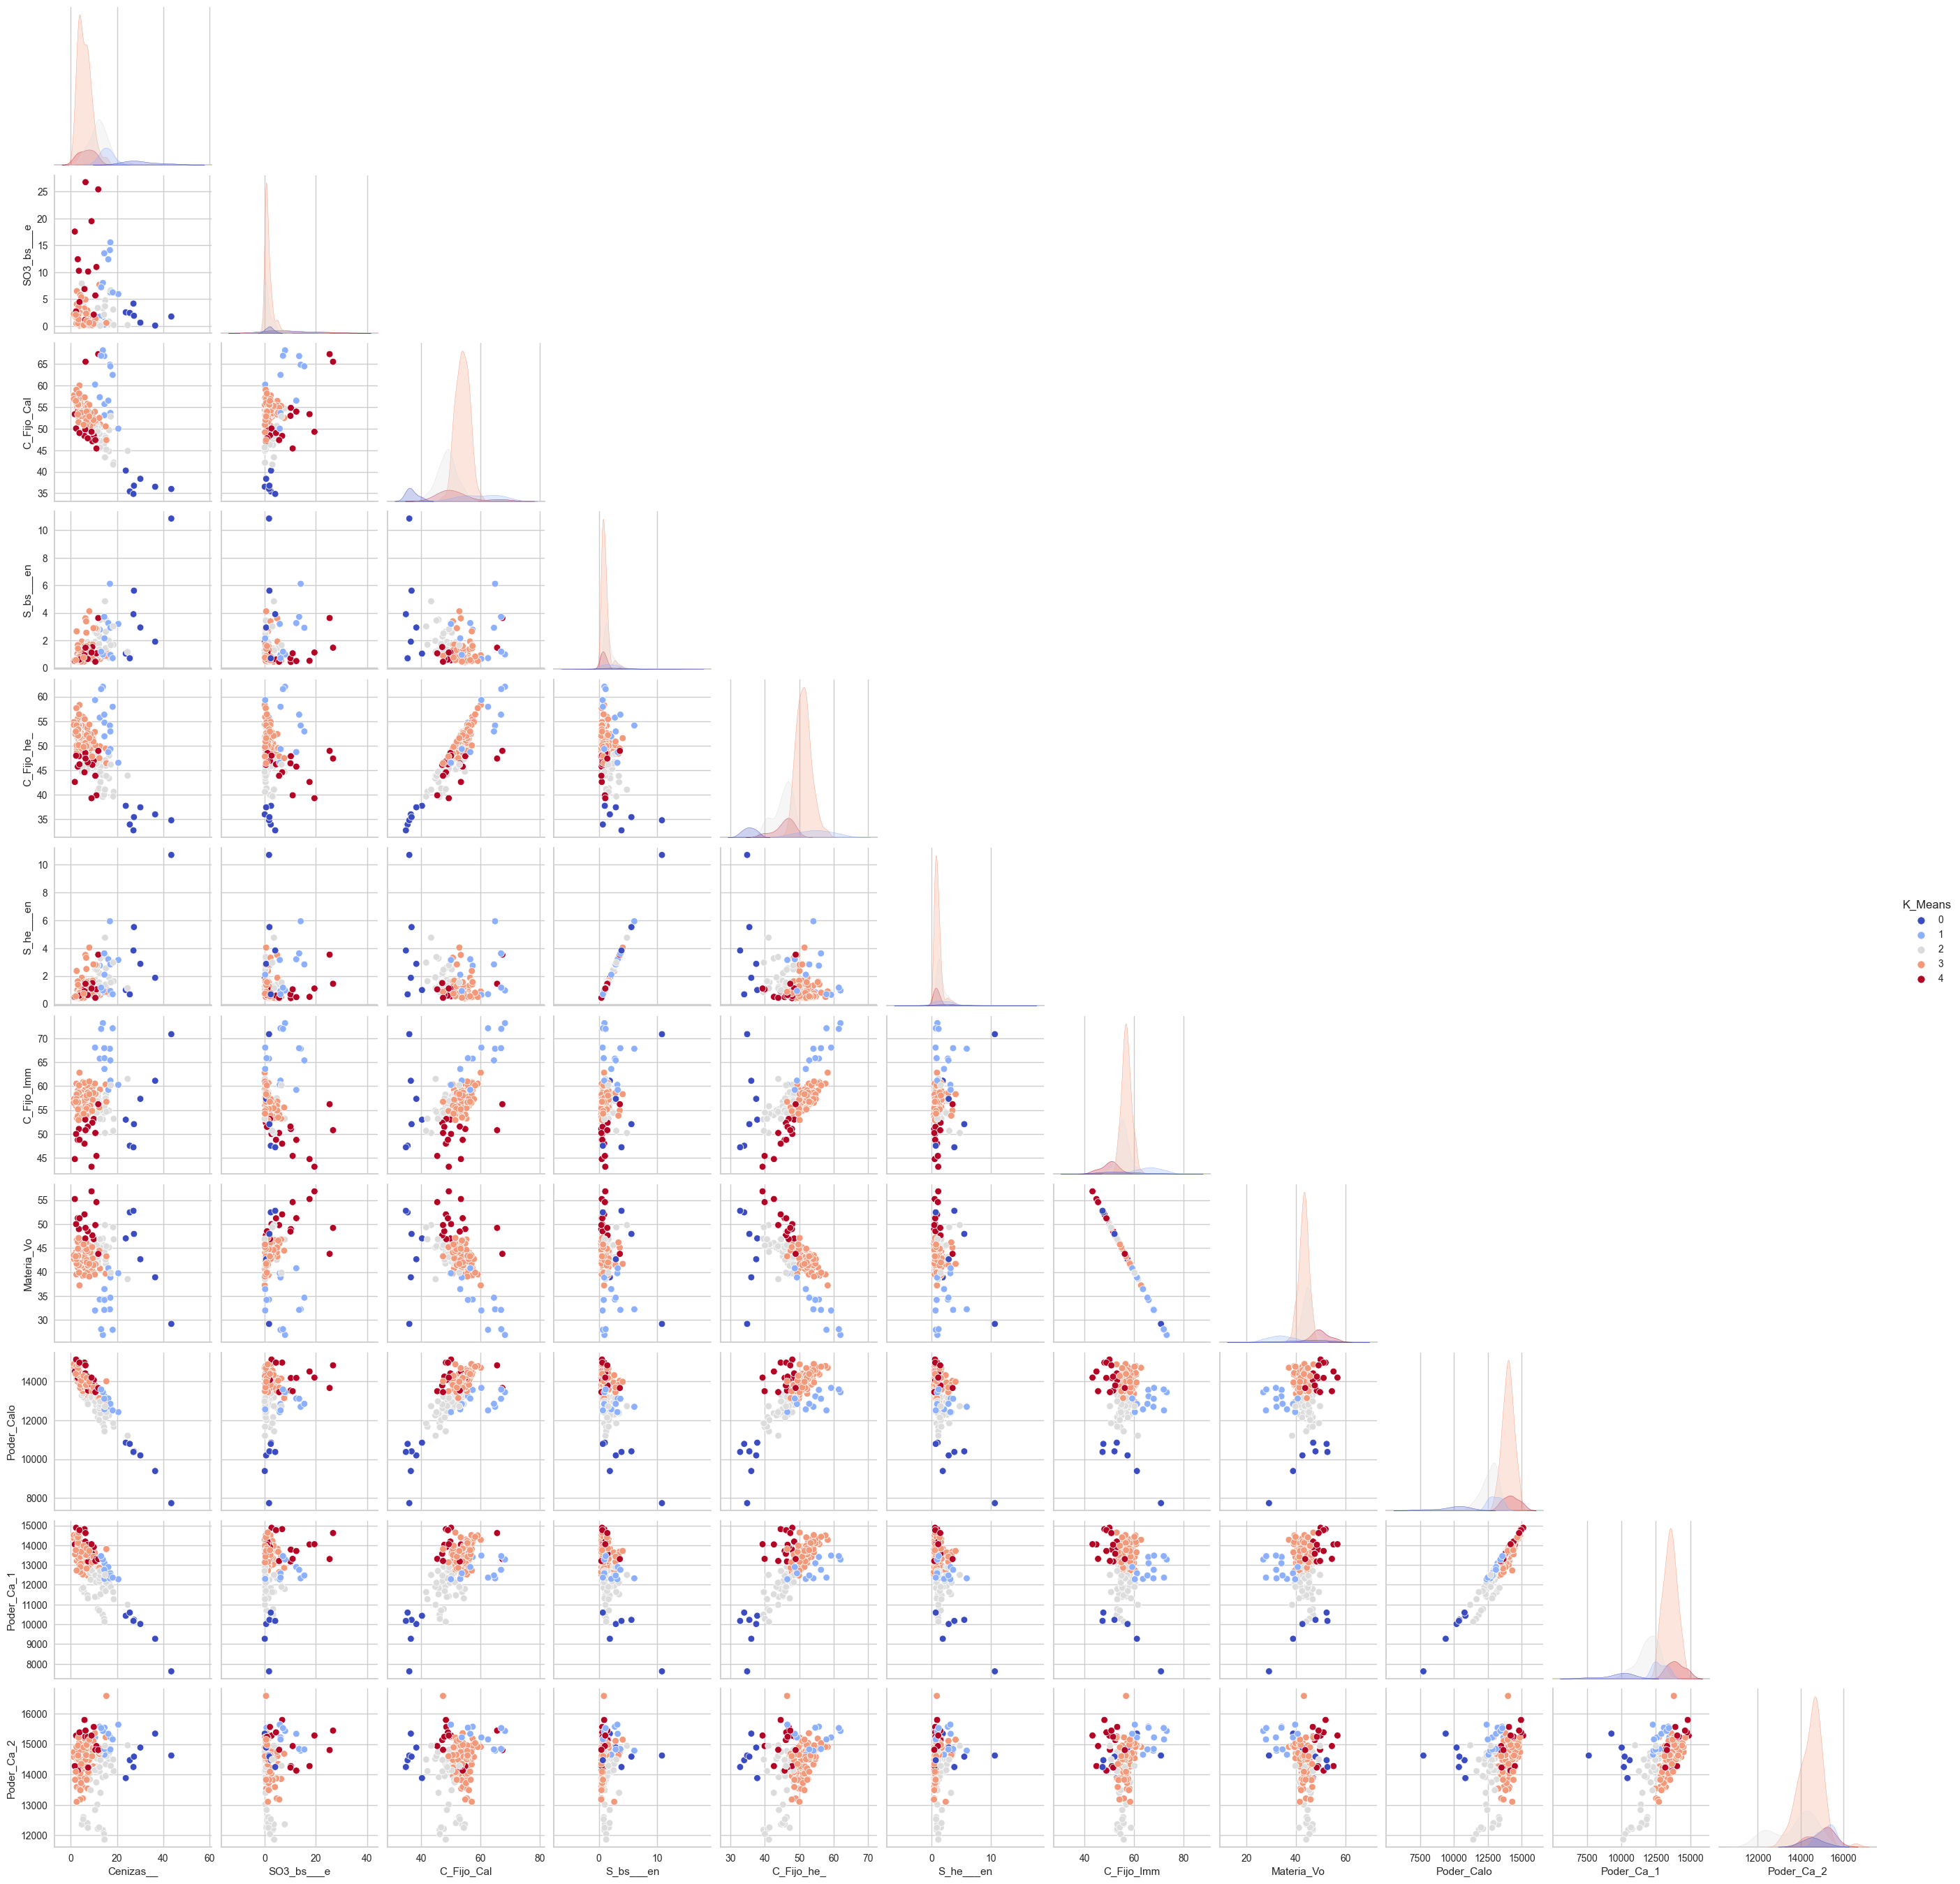

In [45]:
sns.pairplot(data2, hue='K_Means', corner = True, palette = 'coolwarm')

In [91]:
dep = gdp.read_file(
    '/home/camilocorredor/Downloads/DANE Limites Territoriales/DANE Limites Territoriales/DEPARTAMENTO.shp'
    )

Text(0.5, 20.222222222222214, 'Longitude')

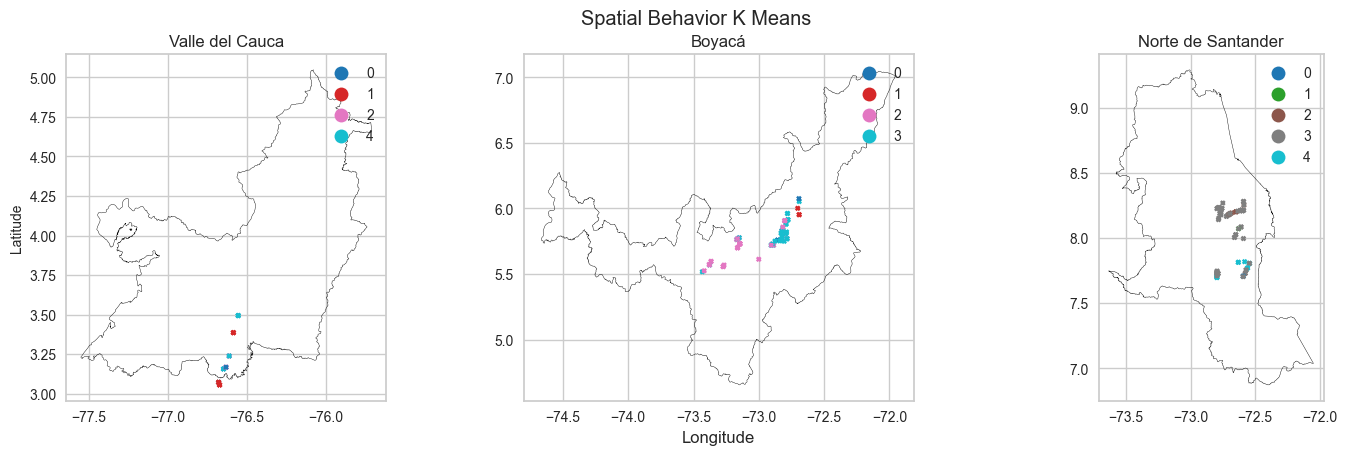

In [136]:
fig, ax = plt.subplots(1,3,figsize=(18,4.5))

dep[dep['NOMBRE_DEP']=='VALLE DEL CAUCA'].plot(ax=ax[0], facecolor='None')
gdf[gdf['Departamen']=='Valle del Cauca'].plot(column = 'K_Means', ax=ax[0], categorical = True, marker = 'x',markersize=8, legend =True)
ax[0].title.set_text('Valle del Cauca')

dep[dep['NOMBRE_DEP']=='BOYACÁ'].plot(ax=ax[1], facecolor='None')
gdf[gdf['Departamen']=='Boyacá'].plot(column = 'K_Means', ax=ax[1], categorical = True, marker = 'x',markersize=8, legend =True)
ax[1].title.set_text('Boyacá')

dep[dep['NOMBRE_DEP']=='NORTE DE SANTANDER'].plot(ax=ax[2], facecolor='None')
gdf[gdf['Departamen']=='Norte de Santander'].plot(column = 'K_Means', ax=ax[2], categorical = True, marker = 'x',markersize=8, legend =True)
ax[2].title.set_text('Norte de Santander')

fig.suptitle('Spatial Behavior K Means')
ax[0].set_ylabel('Latitude', fontsize=10)
ax[1].set_xlabel('Longitude', fontsize='medium')


Clustering Hierachical

<Figure size 1000x1000 with 0 Axes>

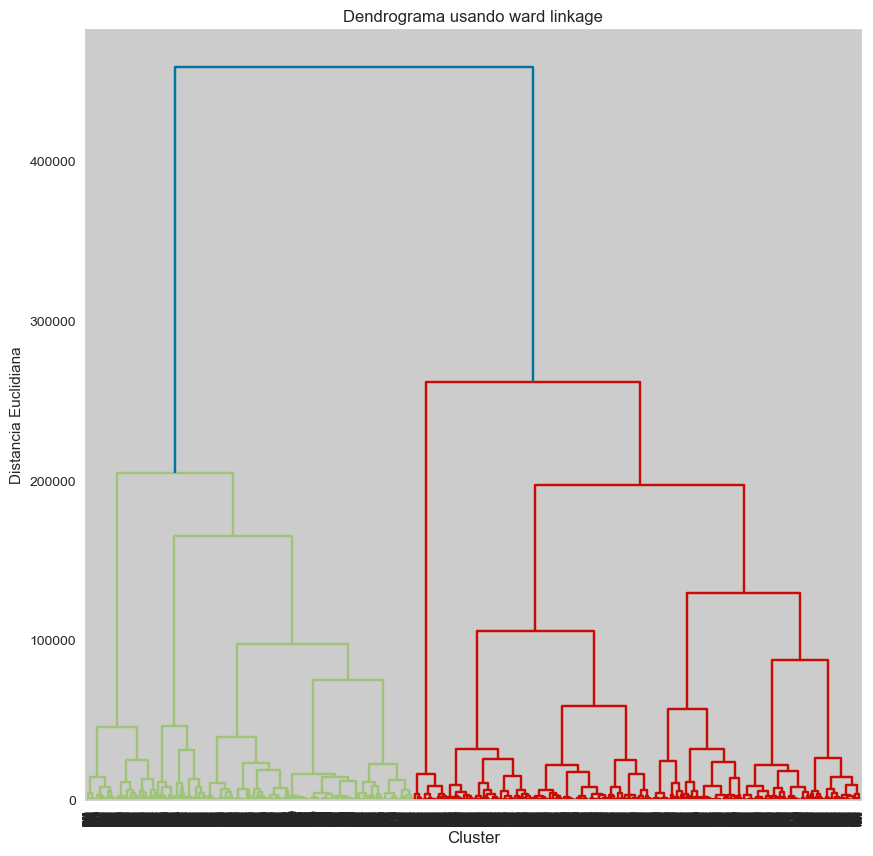

In [ ]:
fig = plt.figure(figsize=(10,10))
dendrogram_plot = dendrogram(linkage(iv[['lon','lat']], method='ward'))
plt.title('Dendrograma usando ward linkage')
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Distancia Euclidiana')
plt.show()

In [ ]:
modelo_hclust_complete = AgglomerativeClustering(
                            affinity = 'euclidean',
                            linkage  = 'complete',
                            distance_threshold = 0.1,
                            n_clusters         = None
                        )
modelo_hclust_complete.fit(X=iv[['lon','lat']])

modelo_hclust_average = AgglomerativeClustering(
                            affinity = 'euclidean',
                            linkage  = 'average',
                            distance_threshold = 0,
                            n_clusters         = None
                        )
modelo_hclust_average.fit(X=iv[['lon','lat']])



/home/camilocorredor/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/home/camilocorredor/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/home/camilocorredor/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


AgglomerativeClustering(affinity='euclidean', distance_threshold=0,
                        n_clusters=None)

In [ ]:
model_hclust_ward = AgglomerativeClustering(
                            affinity = 'euclidean',
                            linkage  = 'ward',
                            #distance_threshold = 0,
                            n_clusters = 100
                     )
model_hclust_ward = model_hclust_ward.fit_predict(X=iv[['lon','lat']])
iv['cluster'] = pd.DataFrame(model_hclust_ward)

/home/camilocorredor/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [ ]:
silhouette_score(iv[['lon','lat']],model_hclust_ward)

0.5389649508287273

In [ ]:
range_n_clusters = range(2, 100)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    
    model_hclust_ward = AgglomerativeClustering(
                            metric = 'euclidean',
                            linkage  = 'ward',
                            #distance_threshold = 0,
                            n_clusters = n_clusters
                     )
    cluster_labels = model_hclust_ward.fit_predict(iv[['lon','lat']])
    silhouette_avg = silhouette_score(iv[['lon','lat']], cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)
    
fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette')
plt.show()

KeyboardInterrupt: 

In [149]:
from sklearn.neighbors import NearestNeighbors

In [217]:
Neighbors = NearestNeighbors(n_neighbors= 6)
Neighbors_fit = Neighbors.fit(pca_data_standard)
distances, indices = Neighbors_fit.kneighbors(pca_data_standard)

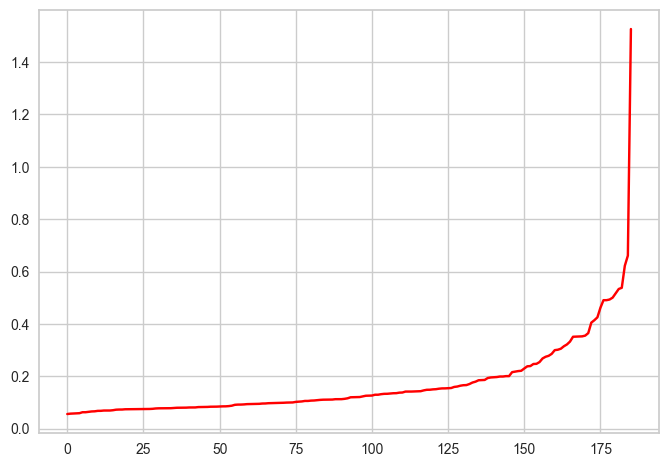

In [275]:
distances_ = np.sort(distances, axis = 0, )
distances_ = distances_[:,5]
plt.plot(distances_, color = 'red')
plt.show()

In [191]:
from itertools import product

In [276]:
eps_values = np.arange(0.3, 0.6, 0.01)
min_samples = np.arange(2,10,1)

print(eps_values)
print(min_samples)

[0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42 0.43
 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56 0.57
 0.58 0.59]
[2 3 4 5 6 7 8 9]


In [277]:
dbscan_paramns = list(product(eps_values,min_samples))
sil_scores = []
labels = 0
idx_elim = []
i = 0

for p in dbscan_paramns: 
    y_pred = DBSCAN(eps= p[0], min_samples=p[1]).fit_predict(pca_data_standard),
    y_pred = np.array(y_pred).ravel()
    if len(np.unique(y_pred)) < 2:
        print(f'Parameters: {p[0]} and {p[1]}. Index: {i}')
        idx_elim.append(i)
        
    else:
        sil_scores.append(silhouette_score(pca_data_standard,y_pred))
    
    i += 1



In [278]:
df_params_tuning = pd.DataFrame.from_records(dbscan_paramns, columns = ['Eps','Min_Samples'])
df_params_tuning['sil_scores'] = sil_scores

pivot_data = pd.pivot_table(df_params_tuning, values='sil_scores',index='Min_Samples',columns='Eps')
pivot_data


Eps              0.30      0.31      0.32      0.33      0.34      0.35  \
Min_Samples                                                               
2            0.458138  0.534025  0.553152  0.560020  0.598818  0.658065   
3            0.462528  0.534025  0.553152  0.560020  0.598818  0.658065   
4            0.554000  0.568681  0.567727  0.571534  0.589208  0.611032   
5            0.552262  0.563321  0.567727  0.571534  0.589208  0.611032   
6            0.527874  0.557211  0.563321  0.563321  0.573923  0.587574   
7            0.516749  0.528735  0.534089  0.548173  0.573923  0.587574   
8            0.516749  0.528735  0.534089  0.548173  0.560230  0.569478   
9            0.516749  0.528735  0.534089  0.548173  0.560230  0.569478   

Eps              0.36      0.37      0.38      0.39  ...      0.50      0.51  \
Min_Samples                                          ...                       
2            0.658065  0.658065  0.658065  0.658065  ...  0.742813  0.742813   
3            0.658065  0.658065  0.658065  0.658065  ...  0.742813  0.742813   
4            0.611032  0.608454  0.608454  0.546653  ...  0.742813  0.742813   
5            0.611032  0.611032  0.611032  0.611032  ...  0.742813  0.742813   
6            0.611032  0.611032  0.611032  0.611032  ...  0.742813  0.742813   
7            0.587574  0.599623  0.611032  0.611032  ...  0.678597  0.742813   
8            0.577144  0.578582  0.589519  0.589519  ...  0.678597  0.678597   
9            0.577144  0.577144  0.577144  0.578582  ...  0.678597  0.678597   

Eps              0.52      0.53      0.54      0.55      0.56      0.57  \
Min_Samples                                                               
2            0.742813  0.742813  0.742813  0.742813  0.742813  0.742813   
3            0.742813  0.742813  0.742813  0.742813  0.742813  0.742813   
4            0.742813  0.742813  0.742813  0.742813  0.742813  0.742813   
5            0.742813  0.742813  0.742813  0.742813  0.742813  0.742813   
6            0.742813  0.742813  0.742813  0.742813  0.742813  0.742813   
7            0.742813  0.742813  0.742813  0.742813  0.742813  0.742813   
8            0.742813  0.742813  0.742813  0.742813  0.742813  0.742813   
9            0.678597  0.678597  0.678597  0.678597  0.742813  0.742813   

Eps              0.58      0.59  
Min_Samples                      
2            0.742813  0.742813  
3            0.742813  0.742813  
4            0.742813  0.742813  
5            0.742813  0.742813  
6            0.742813  0.742813  
7            0.742813  0.742813  
8            0.742813  0.742813  
9            0.742813  0.742813  

[8 rows x 30 columns]

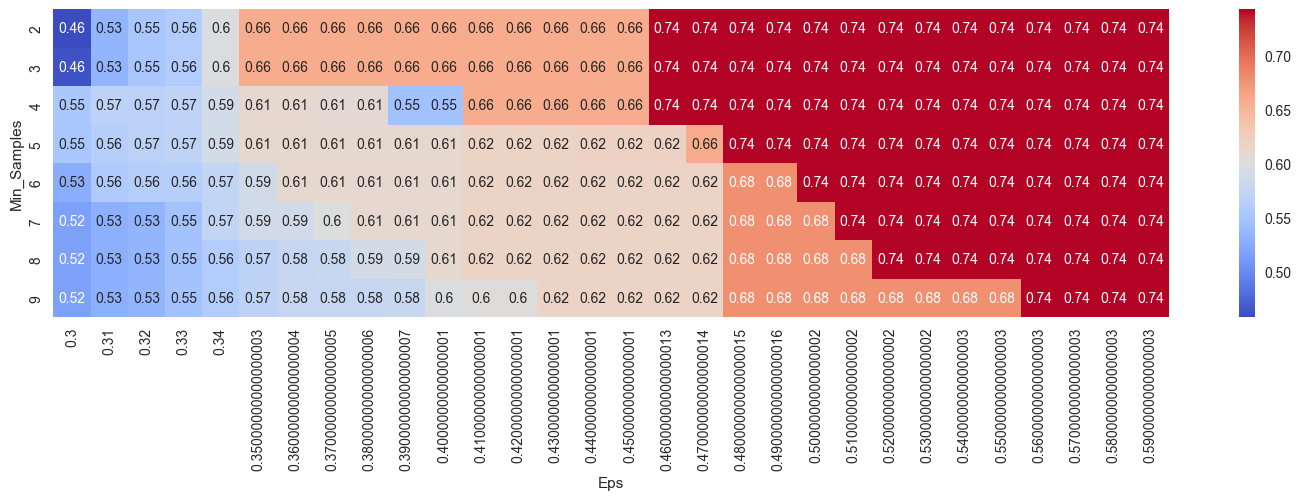

In [279]:
fig, ax  = plt.subplots(figsize =(18,4))
sns.heatmap(pivot_data, annot=True, annot_kws={'size':10}, cmap='coolwarm', ax = ax)
plt.show()

In [280]:
modelo_dbscan = DBSCAN(
                    eps          = 0.46,
                    min_samples  = 5,
                    metric       = 'euclidean',
                )

modelo_dbscan.fit(X=pca_data_scaled)

DBSCAN(eps=0.46)

In [281]:
n_clusters = len(set(modelo_dbscan.labels_)) - (1 if -1 in modelo_dbscan.labels_ else 0)
n_noise    = list(modelo_dbscan.labels_).count(-1)

print(f'Número de clusters encontrados: {n_clusters}')
print(f'Número de outliers encontrados: {n_noise}')

Número de clusters encontrados: 1
Número de outliers encontrados: 10


In [272]:
modelo_dbscan.labels_

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0, -1,  0, -1, -1, -1, -1,  0,  0,  0,  0, -1,  0,  0,  0, -1])